## Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these.

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# I'm setting the seed to assure reproducibility
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read data from CSV file and store in a DataFrame
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# Display the number of rows in the DataFrame
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# Display the number of unique users in the DataFrame
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Display the proportion of users converted in the DataFrame
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Display the number of times the new_page and treatment don't line up in the DataFrame
df[np.logical_and(df['landing_page']=='new_page',df['group']!='treatment')].shape[0] + df[np.logical_and(df['landing_page']=='old_page',df['group']!='control')].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
# Display the information of the DataFrame shows that there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset with these rows removed. Store your new dataframe in **df2**.

In [8]:
# Drop the rows where the new_page and treatment don't line up in the DataFrame
df2 = df.drop(df[np.logical_and(df['landing_page']=='new_page',df['group']!='treatment')].index)
df2 = df2.drop(df2[np.logical_and(df2['landing_page']=='old_page',df2['group']!='control')].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer the below questions.

a. How many unique **user_id**s are in **df2**?

In [10]:
# Display the number of unique users in the new DataFrame
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# Display the value counts of the user_id column
print(df2.user_id.value_counts().head())

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64


c. What is the row information for the repeat **user_id**? 

In [12]:
# Display the rows for the repeated user
df2[df2['user_id'] == df2.user_id.value_counts().index[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Drop the first row of the 2 rows for the repeated user
df2.drop(df2[df2['user_id'] == df2.user_id.value_counts().index[0]].index[0], inplace=True)

`4.` Use **df2** in the below cells to answer the below questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
# Display the mean of the converted column
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
# Display the mean of the converted column for the control group
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
# Display the mean of the converted column for the treatment group
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
# Display the probability that an individual received the new page
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**Conclusion:** Considering the results from a. through d. above, there is no sufficient evedince to say that any of the pages lead to more conversion based on the information provided in the above cells.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I'm going to consider that I need to make the decision just based on all the data provided. I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

Based on my assumption the null and alternative hypotheses are listed below.  

The terms **$p_{old}$** and **$p_{new}$**, are the converted rates for the old and new pages.

**$H_{0}$**: **$p_{new}$** $\leq$ **$p_{old}$** 

**$H_{1}$**: **$p_{new}$** > **$p_{old}$**

or alternetlivly it can be written as:

**$H_{0}$**: **$p_{new}$** - **$p_{old}$** $\leq$ 0

**$H_{1}$**: **$p_{new}$** - **$p_{old}$** > 

**with an $\alpha$ value of 0.05**

`2.` Assuming that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming the they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I'll use a sample size for each page equal to the ones in **ab_data.csv**. And perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. Finally, I'll use the cells below to provide the necessary parts of this simulation.

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
# Display the conversion rate for Pnew
p_new = df2[df2['converted']==1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
# Display the conversion rate for Pold
p_old = df2[df2['converted']==1].shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
# Display the number of rows with the new_page
n_new = df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
# Display the number of rows with the old_page
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Use the NumPy choice function to simulate transactions
# with the same sample size and probability as new page rows in the dataset
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])
new_page_converted.mean()

0.11975775927327782

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Use the NumPy choice function to simulate transactions
# with the same sample size and probability as old page rows in the dataset
old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old, 1-p_old])
old_page_converted.mean()

0.11893387667442212

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
# Display the difference in the means of the simulations
new_page_converted.mean() - old_page_converted.mean()

0.0008238825988556991

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# Use the NumPy choice function to simulate transactions
# with the same sample size and probability as old page rows in the dataset.
# Repeat the simulation 10,000 times
p_diffs = []
for _ in range(10000):
    b_experiment = np.random.choice([1,0], size=n_new, p=[p_new, 1-p_new])
    b_control = np.random.choice([1,0], size=n_old, p=[p_old, 1-p_old])
    p_diffs.append(b_experiment.mean() - b_control.mean())

i. Plot a histogram of the **p_diffs**.

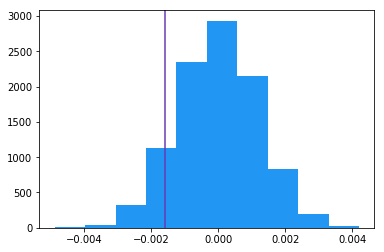

In [26]:
# Calculate the observed difference in means from the dataset
obs_diff = df2[df2['group']=='treatment']['converted'].mean() - df2[df2['group']=='control']['converted'].mean()
# Convert p_diffs to a NumPy array to be able to plot it and do element-wise calculations later on
p_diffs = np.array(p_diffs)

# Plot the sampling distribution of the difference in sample means and the observed difference from the dataset
plt.hist(p_diffs, color='#2196F3')
plt.axvline(x=obs_diff, color='#673AB7');

As expected the graph for sampling distributions of the difference of sample means tends to look like a bell curve for large numbers of iterations.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# Display the p-value
(p_diffs > obs_diff).mean()

0.9067

The value calculated is the p-value and signifies the probability of observing our statistic if the null hypothesis is true. So in our case with a high p-value (greater than the $\alpha$ of 5%) we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null. This implies that there is no significant difference between the new and old pages in terms of conversion.

l. We could also use a built-in function to achieve similar results. Though using the built-in function might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [28]:
# Import statsmodels.api
import statsmodels.api as sm

# Calculate the number of conversions for each group
convert_old = df2[df2['group']=='control']['converted'].sum()
convert_new = df2[df2['group']=='treatment']['converted'].sum()

m. Now I'll use `stats.proportions_ztest` to compute your test statistic and p-value.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

The values agree with the findings we got from parts j. and k., both p-values are way above the 5% $\alpha$ level which means that we have evidence to reject the null hypothesis and that there is no significant difference between the new and old pages in terms of conversion.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I'll check if the result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion, the type of regression I should be performing is a Logistic regression since it is a categorical variable.

The goal is to use **statsmodels** to fit the regression model and see if there is a significant difference in conversion based on which page a customer receives.  However, I'll first create a column for the intercept, and create a dummy variable column for which page each user received. I'll add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
# Add the intercept column
df2['intercept'] = 1
# Add the ab_page column
df2['ab_page'] = df2['group'].map(lambda x: 1 if x == 'treatment' else 0)

I'll use **statsmodels** to import your regression model, instantiate the model, and fit the model using the two columns you created above to predict whether or not an individual converts.

In [31]:
# Instantiate the logistic regression model
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# Fit the model
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [32]:
# Display the summary of the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 04 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:37:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p value for the ab_page in the regression model is 0.190, while the p-value from part II was 0.9. This difference is because the null and alternative hypotheses. In part II our alternative hypothesis is that the new page is getting a better conversions than the old page, while in this section we our alternative hypothesis is that the conversion of the new page is not equal to the conversion of the old page.

The advantages of adding other factors might lead to discovering stronger relationships between our response variable and other predictor variables that we didn't previously consider, this will give us a deeper understanding of how our model is affected with all the different factors. As for the disadvantages there is the issue of multi-collinearity between the predictor variables.

Now other than testing if the conversion rate changes for different pages, I can also add an effect based on which country a user lives. I'll need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

In [33]:
# Load new data and joining it with the previous dataset
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [34]:
# Check the different values for the country column
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [35]:
# Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [36]:
# Instantiate the logistic regression model
lm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
# Fit the model
res2 = lm2.fit()
# Display the summary of the model results
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        20:37:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Based on the p-values being greater than 0.05, it seems that the country doesn't have a significant impact on the conversion rate.

Though I have now looked at the individual factors of country and page on conversion, I'd now look at an interaction between page and country to see if there significant effects on conversion.

In [37]:
# Create a new intereaction variables between new page and countries
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']

In [38]:
# Instantiate the logistic regression model
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
# Fit the model
res3 = lm3.fit()
# Display the summary of the model results
res3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 04 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        20:37:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Based on the p-values still being greater than 0.05 for all coefficients, it seems that neither the countries nor the interactions have a significant impact on the conversion rate.